<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/nifty_%25_above_50_dma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


import duckdb


def calculate_percentage_above_moving_average(periods):
    # Connect to DuckDB
    conn = duckdb.connect("candle_data.duckdb")

    # Query only data from '2018-05-01' onwards
    query = """
        SELECT *
        FROM candle_table
        WHERE date >= '2018-05-01'
        ORDER BY date
    """
    # Read data into a Pandas DataFrame
    data = conn.execute(query).df()

    # Close connection
    conn.close()
    data=data.drop_duplicates(subset=['date'], keep='first')
    # Set index to 'date' and convert to DateTime
    data["date"] = pd.to_datetime(data["date"])
    data.set_index("date", inplace=True)


    # Compute percentage of stocks above moving average
    # Select only numeric columns for comparison
    numeric_cols = data.select_dtypes(include='number').columns

    # Calculate moving average only on numeric columns
    ma = data[numeric_cols].ewm(span=periods, min_periods=periods).mean()

    # Compute which values are above the moving average
    above_ma = data[numeric_cols] > ma
    percentage = (above_ma.sum(axis=1) / len(above_ma.columns)) * 100


    return percentage



# Calculate the percentage of stocks above their 200 DMA for each day
percentage_above_dma = calculate_percentage_above_moving_average(50)
percentage_50_dma=calculate_percentage_above_moving_average(10)
# Download the Bank Nifty index data


In [3]:
conn = duckdb.connect("nifty50_data.duckdb")

# Query only data from '2018-05-01' onwards
query = """
    SELECT *
    FROM nifty50_table
    WHERE date >= '2018-05-01'
    ORDER BY date
"""
# Read data into a Pandas DataFrame
nifty = conn.execute(query).df()

# Close connection
conn.close()

In [4]:
nifty=nifty.drop_duplicates(subset=['date'], keep='first')
nifty.dropna(inplace=True)
# Set index to 'date' and convert to DateTime
nifty["date"] = pd.to_datetime(nifty["date"])
nifty.set_index("date", inplace=True)

In [5]:
# Reindex Bank Nifty index data to match percentage_above_dma
aligned_nifty_close = nifty['close']

aligned_nifty_close.head()

,close
date,
2023-03-27,16985.699219
2023-03-28,16951.699219
2023-03-29,17080.699219
2023-03-31,17359.750000
2023-04-03,17398.050781


In [6]:
percentage_above_dma_30_ema=percentage_50_dma.rolling(window=2).mean()
percentage_above_dma_10_ema=percentage_50_dma.rolling(window=1).mean()
percemtage_above_dma_200_30=percentage_above_dma.rolling(window=5).mean()
percemtage_above_dma_200_10=percentage_above_dma.rolling(window=2).mean()

In [7]:
aligned_nifty_close=aligned_nifty_close.tail(250)
percentage_50_dma=percentage_50_dma.tail(250)
percentage_above_dma_10_ema=percentage_above_dma_10_ema.tail(250)
percentage_above_dma_30_ema=percentage_above_dma_30_ema.tail(250)
percemtage_above_dma_200_30=percemtage_above_dma_200_30.tail(250)
percemtage_above_dma_200_10=percemtage_above_dma_200_10.tail(250)

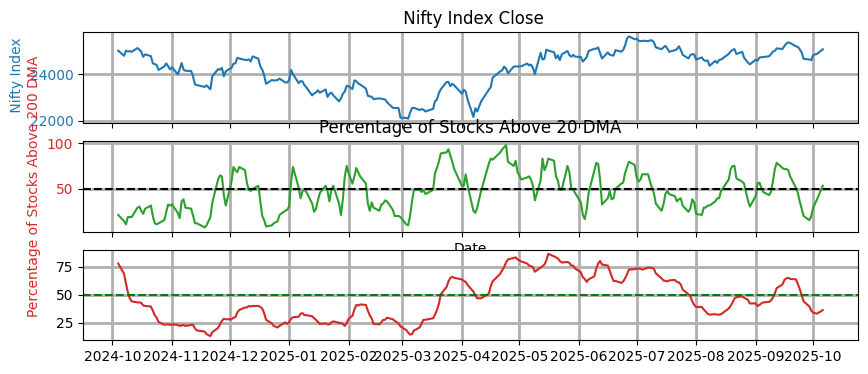

In [8]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel(' Nifty Index', color='tab:blue')
ax1.plot(aligned_nifty_close.index, aligned_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title(' Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 200 DMA', color='tab:red')
#ax2.plot(percentage_above_dma.index, percentage_above_dma, color='tab:red', label='Percentage Above 200 DMA')
#ax2.plot(percentage_50_dma.index, percentage_above_dma_10_ema, color='tab:cyan', label='10-day Moving Average')
ax2.plot(percentage_50_dma.index, percentage_above_dma_30_ema, color='tab:green', label='30-day Moving Average')
ax3.plot(percentage_50_dma.index, percemtage_above_dma_200_30, color='tab:red', label='30-day Moving Average')
#ax3.plot(percentage_50_dma.index, percemtage_above_dma_200_10, color='tab:grey', label='10-day Moving Average')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 20 DMA')
ax2.axhline(y=50, color='black', linestyle='dashed', label='50% Threshold')
ax3.axhline(y=50, color='green', linestyle='dashed', label='50% Threshold')

#ax2.legend()

yloc = YearLocator()
mloc = MonthLocator()
ax1.xaxis.set_major_locator(mloc)
ax2.xaxis.set_major_locator(mloc)
ax3.xaxis.set_major_locator(mloc)
#ax[2].xaxis.set_major_locator(mloc)
ax1.grid(linewidth =2)
ax2.grid(linewidth =2)
ax3.grid(linewidth =2)


plt.show()


In [9]:
print('small : ',round(percentage_above_dma_30_ema.iloc[-1]))
print('large : ',round(percemtage_above_dma_200_30.iloc[-1]))

small :  53
large :  36


In [10]:
signal_S=np.where(percemtage_above_dma_200_10>percemtage_above_dma_200_30,1,-1)
signal=np.where(percentage_above_dma_10_ema>percentage_above_dma_30_ema,1,-1)
result=percentage_above_dma_10_ema#-percentage_above_dma_30_ema
result_L = percentage_above_dma_30_ema

In [11]:
aligned_nifty_close=aligned_nifty_close.tail(200)
result=result.tail(200)
result_L=result_L.tail(200)

In [12]:
aligned_nifty_close.tail(5)

,close
date,
2025-09-29,24634.900391
2025-09-30,24611.099609
2025-10-01,24827.150391
2025-10-03,24876.849609
2025-10-06,25074.900391


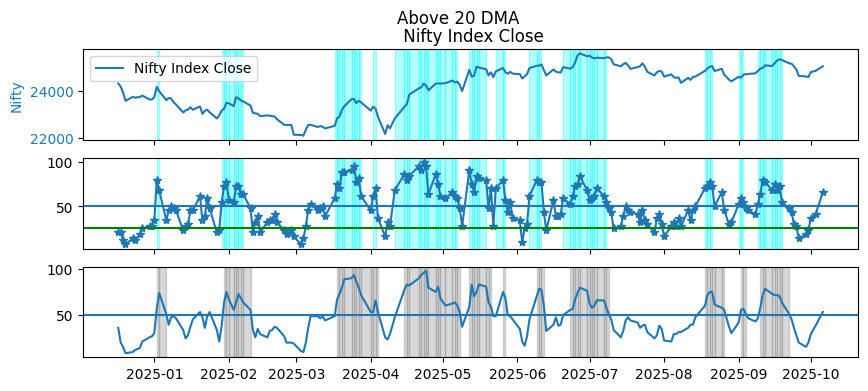

In [13]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(10,4), sharex=True)
ax1.set_ylabel(' Nifty Index', color='tab:blue')
ax1.plot(aligned_nifty_close.index, aligned_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title(' Nifty Index Close')
ax2.plot(result , label='up',linestyle='-', marker='*')
ax3.plot(result_L , label='up')
ax1.legend(loc='upper left')
ax2.axhline(y=50)
ax3.axhline(y=50)
ax2.axhline(y=25,color='g')
ax1.set_ylabel('Nifty')
ax1.legend('ML Signal')
ax1.legend(loc='best')
fig.suptitle('Above 20 DMA')
# Highlighting the regions where Above 20 DMA is below -20
'''
below_threshold = result < 35

for i in range(1, len(aligned_nifty_close.index)):
    if below_threshold[i] and below_threshold[i-1]:
        ax1.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='green', alpha=0.3)
        ax2.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='green', alpha=0.3)
'''

below_threshold = result>50 #result < 22
below_threshold_L = result_L>50 #result < 22
for i in range(1, len(aligned_nifty_close.index)):
    if below_threshold[i] and below_threshold[i-1]:
        ax1.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='cyan', alpha=0.3)
        ax2.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='cyan', alpha=0.3)


for i in range(1, len(aligned_nifty_close.index)):
    if below_threshold_L[i] and below_threshold_L[i-1]:
        #ax1.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='green', alpha=0.3)
        ax3.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='gray', alpha=0.3)

plt.show()


In [14]:
result[-10:].to_csv('result.csv')

In [15]:
S=np.where(signal_S<0,signal,1)

1


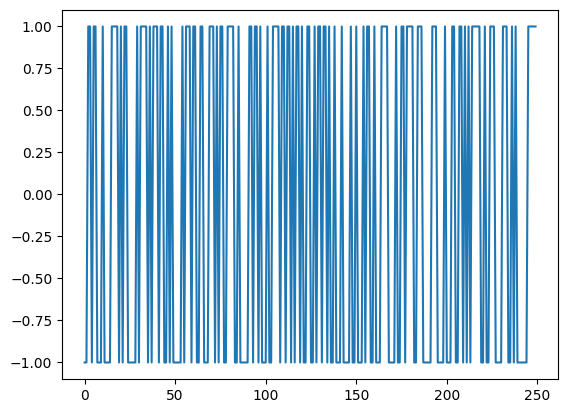

In [16]:
print(signal[-1])
pd.Series(signal).plot();

In [17]:
import numpy as np
import pandas as pd

def exposure_tanh_dynamic_k_safe(breadth, *,
                                 pct_input=True,          # True if series is % above DMA
                                 center_mode='fixed',     # 'fixed' or 'rolling'
                                 fixed_center=0.5,        # 50% midpoint for % breadth
                                 k_scale=1.0, ema_span=5,
                                 window=120, min_k=0.2, clip_abs=4.0,
                                 robust=True) -> pd.Series:
    """
    Robust signed exposure:
        E_t = tanh( clip( (B_tilde - center_t) / k_t, [-clip_abs, clip_abs] ) )
    where B_tilde is EMA-smoothed breadth in [0,1] (if pct_input=True),
    center_t is 0.5 (fixed) or a rolling mean, and
    k_t = k_scale * rolling scale (STD or MAD), floored at min_k.
    Returns E_t in [-1, 1].
    """
    b = pd.Series(breadth, dtype=float)

    # Normalize % inputs to [0,1]
    if pct_input:
        if b.max() > 1.0 + 1e-12:
            b = b / 100.0
        b = b.clip(0.0, 1.0)

    # Smooth
    B = b.ewm(span=ema_span, adjust=False).mean()

    # Centering: fixed 0.5 or rolling mean
    if center_mode == 'rolling':
        center = B.rolling(window, min_periods=max(20, window//3)).mean()
        center = center.fillna(fixed_center)
    else:
        center = pd.Series(fixed_center, index=B.index)

    # Rolling scale: robust MAD -> sigma, or standard deviation
    minp = max(20, window//3)
    if robust:
        med = B.rolling(window, min_periods=minp).median()
        mad = (B - med).abs().rolling(window, min_periods=minp).median()
        scale = 1.4826 * mad
    else:
        scale = B.rolling(window, min_periods=minp).std()

    # Fallbacks & floor for k_t
    global_scale = np.nanmedian(scale.replace(0, np.nan))
    if not np.isfinite(global_scale) or global_scale <= 0:
        global_scale = 0.1
    k_t = (scale.fillna(global_scale) * float(k_scale)).clip(lower=float(min_k))

    # Signed, clipped input to tanh
    x = ((B - center) / k_t).clip(-float(clip_abs), float(clip_abs))
    E_t = np.tanh(x)
    E_t.name = "E_t"
    return E_t


In [18]:
exp=exposure_tanh_dynamic_k_safe(result)
exp_L=exposure_tanh_dynamic_k_safe(result_L)

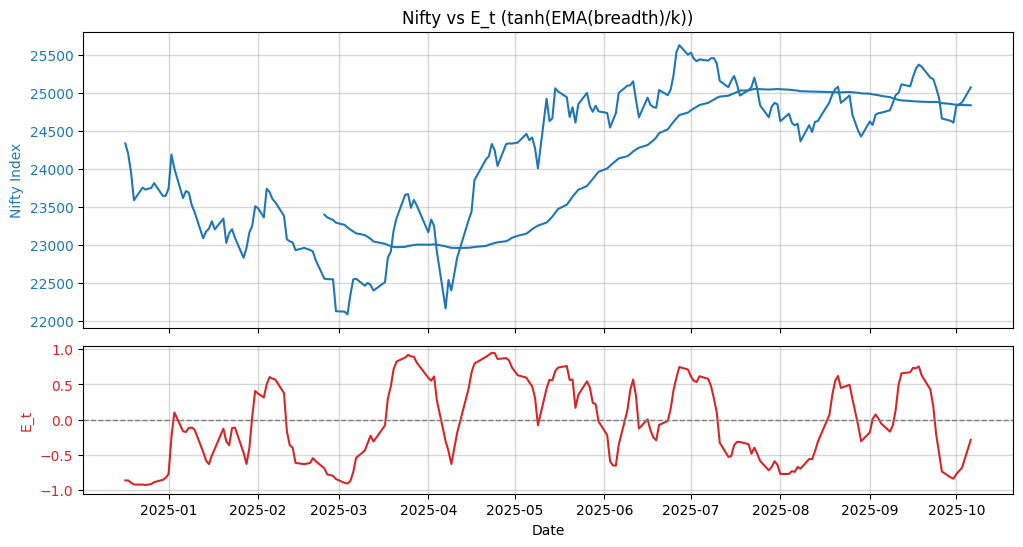

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, AutoDateFormatter

# --- 1) Ensure datetime indexes
aligned_nifty_close.index = pd.to_datetime(aligned_nifty_close.index)
percentage_above_dma.index = pd.to_datetime(percentage_above_dma.index)

# --- 2) Build E_t series (replace `exp` with your computed E_t array/series)
# If `exp` is an array, align it to the *last len(exp)* dates of percentage_above_dma
E_t = pd.Series(exp, index=percentage_above_dma.index[-len(exp):], name='E_t')

# --- 3) Join & drop missing dates so x and y lengths match
df = pd.concat({'nifty': aligned_nifty_close, 'E_t': E_t}, axis=1).dropna()

# --- 4) Plot: two subplots, shared x-axis
fig, (ax_price, ax_E) = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True,
    gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.08}
)

# Top: Nifty index
ax_price.plot(df.index, df['nifty'], color='tab:blue', label='Nifty Index Close')
ax_price.plot(df.index, df['nifty'].rolling(window=50).mean(), color='tab:blue', label='Nifty Index Close')
ax_price.set_ylabel('Nifty Index', color='tab:blue')
ax_price.tick_params(axis='y', labelcolor='tab:blue')
ax_price.set_title('Nifty vs E_t (tanh(EMA(breadth)/k))')
ax_price.grid(True, linewidth=1, alpha=0.5)

# Bottom: E_t
ax_E.plot(df.index, df['E_t'], color='tab:red', label='E_t')
ax_E.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_E.set_ylabel('E_t', color='tab:red')
ax_E.tick_params(axis='y', labelcolor='tab:red')
ax_E.set_ylim(-1.05, 1.05)
ax_E.grid(True, linewidth=1, alpha=0.5)
ax_E.set_xlabel('Date')

# X-axis formatting on the bottom axis
mloc = MonthLocator()
ax_E.xaxis.set_major_locator(mloc)
ax_E.xaxis.set_major_formatter(AutoDateFormatter(mloc))

fig.tight_layout()
plt.show()


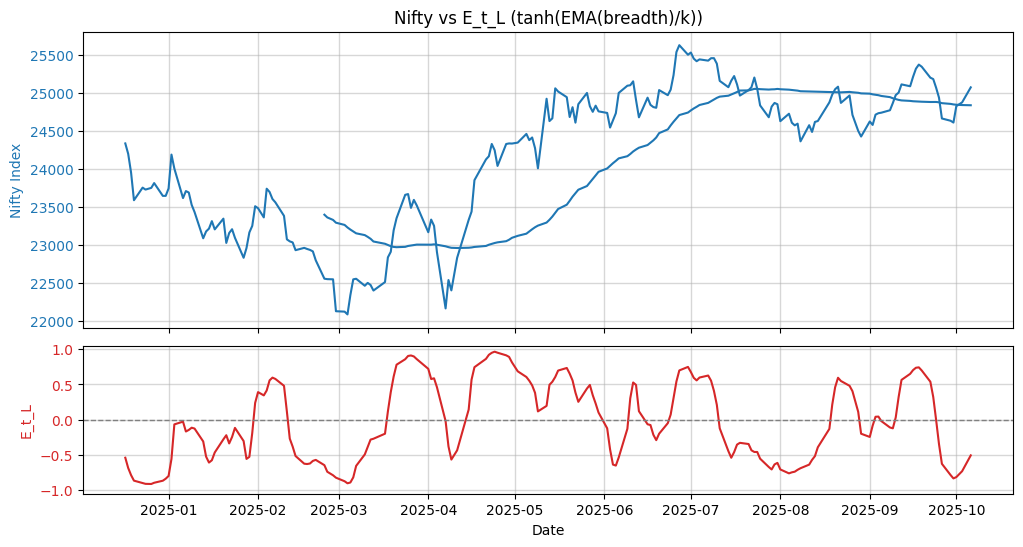

In [20]:

# --- 1) Ensure datetime indexes
aligned_nifty_close.index = pd.to_datetime(aligned_nifty_close.index)
percentage_above_dma.index = pd.to_datetime(percentage_above_dma.index)

# --- 2) Build E_t series (replace `exp` with your computed E_t array/series)
# If `exp` is an array, align it to the *last len(exp)* dates of percentage_above_dma
E_t_L = pd.Series(exp_L, index=percentage_above_dma.index[-len(exp_L):], name='E_Large')

# --- 3) Join & drop missing dates so x and y lengths match
df = pd.concat({'nifty': aligned_nifty_close, 'E_t_L': E_t_L}, axis=1).dropna()

# --- 4) Plot: two subplots, shared x-axis
fig, (ax_price, ax_E) = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True,
    gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.08}
)

# Top: Nifty index
ax_price.plot(df.index, df['nifty'], color='tab:blue', label='Nifty Index Close')
ax_price.plot(df.index, df['nifty'].rolling(window=50).mean(), color='tab:blue', label='Nifty Index Close')
ax_price.set_ylabel('Nifty Index', color='tab:blue')
ax_price.tick_params(axis='y', labelcolor='tab:blue')
ax_price.set_title('Nifty vs E_t_L (tanh(EMA(breadth)/k))')
ax_price.grid(True, linewidth=1, alpha=0.5)

# Bottom: E_t
ax_E.plot(df.index, df['E_t_L'], color='tab:red', label='E_t_L')
ax_E.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_E.set_ylabel('E_t_L', color='tab:red')
ax_E.tick_params(axis='y', labelcolor='tab:red')
ax_E.set_ylim(-1.05, 1.05)
ax_E.grid(True, linewidth=1, alpha=0.5)
ax_E.set_xlabel('Date')

# X-axis formatting on the bottom axis
mloc = MonthLocator()
ax_E.xaxis.set_major_locator(mloc)
ax_E.xaxis.set_major_formatter(AutoDateFormatter(mloc))

fig.tight_layout()
plt.show()
